# MSDS 422 - Practical Machine Learning - Week 9 - Assignment

##### Author: Jason De Melo - 3/6/2022

## Import Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dropout, SimpleRNN, LSTM, Dense, Flatten, GRU
assert tf.__version__ >= "2.0"

# Common imports
import os
import re
import string
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from IPython.display import Image
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import datetime as dt
import pandas_datareader as pdr

# Natural Language Toolkit (NLTK)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### Import the historical data for S&P 500 index

In [2]:
filename = "SP500.csv"
if not [each for each in os.listdir('.') if each == filename]:
    data = pdr.get_data_yahoo('^GSPC', start = dt.datetime(2017,3,1), end = dt.datetime(2022,2,28))
    data.reset_index(inplace=True)
    data.columns = ['date', 'high', 'low', 'open', 'close', 'volume', 'adj_close']
    #data.set_index('date', inplace=True)
    data.to_csv("SP500.csv", encoding='utf-8')
    #data['date'] = pd.to_datetime(data['date']).value
    #data['date_num'] = data['date'].values.astype(float)
    #data.set_index('date', inplace=True)
else:
    data = pd.read_csv(filename, encoding='utf-8', parse_dates=['date'])
    #data['date'] = pd.to_datetime(data['date'])
    #data['date_num'] = data['date'].values.astype(float)
    #data.set_index('date', inplace=True)
data.head()

,date,high,low,open,close,volume,adj_close
0,2017-03-01,2400.979980,2380.129883,2380.129883,2395.959961,4345180000,2395.959961
1,2017-03-02,2394.750000,2380.169922,2394.750000,2381.919922,3821320000,2381.919922
2,2017-03-03,2383.889893,2375.389893,2380.919922,2383.120117,3555260000,2383.120117
3,2017-03-06,2378.800049,2367.979980,2375.229980,2375.310059,3232700000,2375.310059
4,2017-03-07,2375.120117,2365.510010,2370.739990,2368.389893,3518390000,2368.389893


In [3]:
data.describe()

,high,low,open,close,volume,adj_close
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,3205.339841,3170.685044,3188.838792,3189.184883,3.867971e+09,3189.184883
std,692.549068,685.400610,688.961143,689.307952,1.067455e+09,689.307952
min,2300.729980,2191.860107,2290.709961,2237.399902,1.296540e+09,2237.399902
25%,2708.744995,2677.385010,2691.104980,2692.189941,3.233955e+09,2692.189941
50%,2931.149902,2903.820068,2918.459961,2919.370117,3.589930e+09,2919.370117
75%,3643.310059,3608.959961,3634.839966,3632.529907,4.155015e+09,3632.529907
max,4818.620117,4780.040039,4804.509766,4796.560059,9.878040e+09,4796.560059


## Data Preparation - Technical Indicators

>##### code extracted from <a href="https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb">Towards Data Science</a> website.

#### Simple Moving Average (SMA)

Simple Moving Average is one of the most common technical indicators. SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock. As defined above, I will create a slow SMA (SMA_15) and a fast SMA (SMA_5). To provide Machine Learning algorithms with already engineered factors, one can also use (SMA_15/SMA_5) or (SMA_15 - SMA_5) as a factor to capture the relationship between these two moving averages.

In [4]:
def sma(dataset: pd.DataFrame, sma_slow: int = 15, sma_fast: int = 5) -> pd.DataFrame:
    dataset['sma_slow'] = dataset['adj_close'].transform(lambda x: x.rolling(window=sma_slow).mean())
    dataset['sma_fast'] = dataset['adj_close'].transform(lambda x: x.rolling(window=sma_fast).mean())
    dataset['sma_ratio'] = dataset['sma_slow'] / dataset['sma_fast']
    return dataset

#### Simple Moving Average Volume

Similar to Simple Moving Average of price, a simple moving average of volume provides insights into the strength of signal that the stock displays.

In [5]:
def smav(dataset: pd.DataFrame, sma_slow: int = 15, sma_fast: int = 5) -> pd.DataFrame:
    dataset['smav_slow'] = dataset['volume'].transform(lambda x: x.rolling(window=sma_slow).mean())
    dataset['smav_fast'] = dataset['volume'].transform(lambda x: x.rolling(window=sma_fast).mean())
    dataset['smav_ratio'] = dataset['smav_fast'] / dataset['smav_slow']
    return dataset

#### Wilder’s Smoothing

Before moving on to the next indicator, I would like to mention another type of smoothening or moving average that is commonly used with other indicators. Although SMA is quite common, it contains a bias of giving equal weight to each value in the past. To solve this, Wells Wilder introduced a new version of smoothening that places more weight on the recent events. We will use Wilder’s Smoothing for most of our following indicators, and below is the function that can be generally used to obtain this Smoothing.

In [6]:
def wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    wilder = np.array([np.nan]*len(data))
    wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        wilder[i] = (wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(wilder)

#### Average True Range (ATR)

Average True Range is a common technical indicator used to measure volatility in the market, measured as a moving average of True Ranges. A higher ATR of a company implied higher volatility of the stock. ATR however is primarily used in identifying when to exit or enter a trade rather than the direction in which to trade the stock.<p>
As defined above, a slow ATR represents 5 days moving average and fast ATR represents 15 days moving average.<p>
True Range is defined as maximum of:
1. High - Low
2. abs(High - Previous Close)
3. abs(Low - Previous Close)

In [7]:
def atr(dataset: pd.DataFrame, wilder_slow: int = 15, wilder_fast: int = 5) -> pd.DataFrame:
    dataset['prev_close'] = dataset['close'].shift(1)
    dataset['tr'] = np.maximum((dataset['high'] - dataset['low']),
                                np.maximum(abs(dataset['high'] - dataset['prev_close']),
                                           abs(dataset['prev_close'] - dataset['low'])))
    dataset['atr_slow'] = wilder(dataset['tr'], wilder_slow)
    dataset['atr_fast'] = wilder(dataset['tr'], wilder_fast)
    dataset['atr_ratio'] = dataset['atr_fast'] / dataset['atr_slow']
    return dataset

#### Average Directional Index (ADX)

Average Directional Index was developed by Wilder to assess the strength of a trend in stock prices. Two of its main components, +DI and -DI helps in identifying the direction of the trend. In general, an ADX of 25 or above indicates a strong trend and an ADX of less than 20 indicates a weak trend. The calculation of ADX is quite complex and requires certain steps.

In [8]:
def adx(dataset: pd.DataFrame, adx_slow: int = 15, adx_fast: int = 5) -> pd.DataFrame:
    dataset['prev_high'] = dataset['high'].shift(1)
    dataset['prev_low'] = dataset['low'].shift(1)

    # +DM
    dataset['+dm'] = np.where(~np.isnan(dataset.prev_high),
                              np.where((dataset['high'] > dataset['prev_high']) & 
                                      ((dataset['high'] - dataset['prev_high']) > (dataset['prev_low'] - dataset['low'])),
                                        dataset['high'] - dataset['prev_high'], 0), np.nan)
    dataset['+dm_fast'] = wilder(dataset['+dm'], adx_fast)
    dataset['+dm_slow'] = wilder(dataset['+dm'], adx_slow)

    # -DM
    dataset['-dm'] = np.where(~np.isnan(dataset.prev_low),
                              np.where((dataset['prev_low'] > dataset['low']) & 
                                      ((dataset['prev_low'] - dataset['low']) > (dataset['high'] - dataset['prev_high'])),
                                        dataset['prev_low'] - dataset['low'], 0), np.nan)
    dataset['-dm_fast'] = wilder(dataset['-dm'], adx_fast)
    dataset['-dm_slow'] = wilder(dataset['-dm'], adx_slow)

    # +DI
    dataset['+di_fast'] = (dataset['+dm_fast'] / dataset['atr_fast']) * 100
    dataset['+di_slow'] = (dataset['+dm_slow'] / dataset['atr_slow']) * 100

    # -DI
    dataset['-di_fast'] = (dataset['-dm_fast'] / dataset['atr_fast']) * 100
    dataset['-di_slow'] = (dataset['-dm_slow'] / dataset['atr_slow']) * 100

    # DX
    dataset['dx_fast'] = (np.round(abs(dataset['+di_fast'] - dataset['-di_fast']) / (dataset['+di_fast'] + dataset['-di_fast']) * 100))
    dataset['dx_slow'] = (np.round(abs(dataset['+di_slow'] - dataset['-di_slow']) / (dataset['+di_slow'] + dataset['-di_slow']) * 100))
    
    # ADX
    dataset['adx_fast'] = wilder(dataset['dx_fast'], adx_fast)
    dataset['adx_slow'] = wilder(dataset['dx_slow'], adx_slow)

    return dataset


#### Stochastic Oscillators

Stochastic oscillator is a momentum indicator aiming at identifying overbought and oversold securities and is commonly used in technical analysis.

In [9]:
def stochastic_oscillator(dataset: pd.DataFrame, stoch_slow: int = 15, stoch_fast: int = 5) -> pd.DataFrame:
    dataset['stoch_fast_min'] = dataset['low'].transform(lambda x: x.rolling(window=stoch_fast).min())
    dataset['stoch_fast_max'] = dataset['high'].transform(lambda x: x.rolling(window=stoch_fast).max())

    dataset['stoch_slow_min'] = dataset['low'].transform(lambda x: x.rolling(window=stoch_slow).min())
    dataset['stoch_slow_max'] = dataset['high'].transform(lambda x: x.rolling(window=stoch_slow).max())

    dataset['stochastic_fast'] = ((dataset['close'] - dataset['stoch_fast_min']) / (dataset['stoch_fast_max'] - dataset['stoch_fast_min'])) * 100
    dataset['stochastic_slow'] = ((dataset['close'] - dataset['stoch_slow_min']) / (dataset['stoch_slow_max'] - dataset['stoch_slow_min'])) * 100

    dataset['stochastic_%fast'] = dataset['stochastic_fast'].rolling(window=stoch_fast).mean()
    dataset['stochastic_%slow'] = dataset['stochastic_fast'].rolling(window=stoch_slow).mean()

    dataset['stochastic_ratio'] = dataset['stochastic_%fast'] / dataset['stochastic_%slow']

    return dataset


#### Relative Strengh Index (RSI)

RSI is one of the most common momentum indicator aimed at quantifies price changes and the speed of such change.

In [10]:
#TODO: implement RSI
# all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
# all_data['Up'] = all_data['Diff']
# all_data.loc[(all_data['Up']<0), 'Up'] = 0

# all_data['Down'] = all_data['Diff']
# all_data.loc[(all_data['Down']>0), 'Down'] = 0 
# all_data['Down'] = abs(all_data['Down'])

# all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
# all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

# all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
# all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

# all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
# all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

# all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
# all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

# all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

#### Moving Average Convergence Divergence (MACD)

MACD uses two exponentially moving averages and creates a trend analysis based on their convergence or divergence. Although most commonly used MACD slow and fast signals are based on 26 days and 12 days respectively, I have used 15 days and 5 days to be consistent with other indicators.

In [11]:
#TODO: implement MACD
# all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
# all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
# all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

#### Bollinger Bands

Bollinger bands capture the volatility of a stock and are used to identify overbought and oversold stocks. Bollinger bands consists of three main elements: The simple moving average line, an upper bound which is 2 standard deviations above moving average and a lower bound which is 2 standard deviations below moving average.

In [12]:
#TODO: implement BB
# all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
# all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
# all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
# all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

#### Rate of Change

Rate of change is a momentum indicator that explains a price momentum relative to a price fixed period before.

In [13]:
#TODO: implement rate of change
# all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15)) 

## Pre-process the dataset

First, add the additional independent variables. The technical indicators, in this exercise.

In [14]:
data_enriched = data.copy()

In [15]:
data_enriched = sma(data_enriched)
#data_enriched = smav(data_enriched)
#data_enriched = atr(data_enriched)
#data_enriched = adx(data_enriched)
#data_enriched = stochastic_oscillator(data_enriched)
data_enriched = data_enriched.fillna(0)
data_enriched.head(5)

,date,high,low,open,close,volume,adj_close,sma_slow,sma_fast,sma_ratio
0,2017-03-01,2400.979980,2380.129883,2380.129883,2395.959961,4345180000,2395.959961,0.0,0.00000,0.0
1,2017-03-02,2394.750000,2380.169922,2394.750000,2381.919922,3821320000,2381.919922,0.0,0.00000,0.0
2,2017-03-03,2383.889893,2375.389893,2380.919922,2383.120117,3555260000,2383.120117,0.0,0.00000,0.0
3,2017-03-06,2378.800049,2367.979980,2375.229980,2375.310059,3232700000,2375.310059,0.0,0.00000,0.0
4,2017-03-07,2375.120117,2365.510010,2370.739990,2368.389893,3518390000,2368.389893,0.0,2380.93999,0.0


Second, normalize the data. Notice the date column is preserved.

In [16]:
scaler = MinMaxScaler()

X = data_enriched.loc[:, (data_enriched.columns != 'date') & (data_enriched.columns != 'adj_close')]
y = np.array(data_enriched['adj_close'].copy())
y = y.reshape(-1,1)

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

data_scaled = X.copy()
for i in range(0, X_scaled.shape[1]):
    data_scaled.iloc[:,i] = X_scaled[:,i]

data_scaled.head(5)

,high,low,open,close,volume,sma_slow,sma_fast,sma_ratio
0,0.039815,0.072742,0.035572,0.061958,0.355257,0.0,0.00000,0.0
1,0.037341,0.072758,0.041388,0.056472,0.294212,0.0,0.00000,0.0
2,0.033028,0.070911,0.035886,0.056941,0.263208,0.0,0.00000,0.0
3,0.031006,0.068048,0.033622,0.053889,0.225620,0.0,0.00000,0.0
4,0.029545,0.067093,0.031836,0.051185,0.258912,0.0,0.49752,0.0


Next, split the dataset into training and test sets

In [17]:
training_size = int(len(data_scaled) * 0.8)
train_scaled, test_scaled = data_scaled[0:training_size], data_scaled[training_size:len(data_scaled)]
y_train_scaled, y_test_scaled = y_scaled[0:training_size], y_scaled[training_size:len(y_scaled)]

print(f"Size of dataset: {len(data_scaled)} - Shape of dataset: {data_scaled.shape}")
print(f"Size of training set: {len(train_scaled)} - Shape of training set: {train_scaled.shape}")
print(f"Size of test set: {len(test_scaled)} - Shape of test set: {test_scaled.shape}")

Size of dataset: 1259 - Shape of dataset: (1259, 8)
Size of training set: 1007 - Shape of training set: (1007, 8)
Size of test set: 252 - Shape of test set: (252, 8)


In [18]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asarray(data_sequences)

The model we are about to build will need to receive some observations about the past to predict the future. The past observations will not explicitly indicate the timestamp but will receive what we call a window of data points. In this example, we will define a window of 90 data points, where each data point has all the independent variables.<p>
Each learning example consists of a window of past observations that can have one or more features. The target variable can be a single or a sequence of targets. In this example, the model learns to predict a single-step value. The input structure must be in the following format [training examples, time steps, features]. Our design has 42 features with a window of 90 timesteps.<p>
More details, please check <a href="https://towardsdatascience.com/lstm-and-bidirectional-lstm-for-regression-4fddf910c655#:~:text=LSTM%20is%20a%20Gated%20Recurrent%20Neural%20Network%2C%20and,some%20memory%20pool%20that%20has%20two%20key%20vectors%3A">here</a>.

In [19]:
# Specifying how many values to predict
time_step = 1

# Training data
X_train_scaled = train_scaled.to_numpy()
y_train_scaled = y_scaled[time_step:test_scaled.index[0]] #.to_numpy()

# Testing data
X_test_scaled = test_scaled[0:-time_step].to_numpy()
y_test_scaled = y_scaled[test_scaled.index[0] + time_step:] #.to_numpy()

# Generating the sequences
X_train_seq = create_sequence(X_train_scaled, 90)
X_test_seq = create_sequence(X_test_scaled, 90)
y_train_seq = y_train_scaled[-X_train_seq.shape[0]:]
y_test_seq = y_test_scaled[-X_test_seq.shape[0]:]

print(f'Training data shape - X_train {X_train_seq.shape}, y_train {y_train_seq.shape}')
print(f'Testing data shape - X_test {X_test_seq.shape}, y_test {y_test_seq.shape}')

Training data shape - X_train (917, 90, 8), y_train (917, 1)
Testing data shape - X_test (161, 90, 8), y_test (161, 1)


## Create the Model

#### Auxiliary functions

In [20]:
def evaluate_predictions(predictions, y_test, outliers):
    ratio = []
    differences = []
    for pred in range(len(y_test)):
        ratio.append((y_test[pred]/predictions[pred])-1)
        differences.append(abs(y_test[pred]- predictions[pred]))
    
    
    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)
    
    return ratio, differences, outliers

def loss_graph(history):
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

#### Model 1

In [21]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train_seq.shape[1],X_train_seq.shape[-1]), dropout=0.5)))
model1.add(Bidirectional(LSTM(units=16, dropout=0.5)))
model1.add(Dense(units=1))
model1.compile(optimizer='rmsprop', loss='mean_squared_error')

In [22]:
history1 = model1.fit(X_train_seq, y_train_seq, epochs=15, batch_size=16)

Epoch 1/15
58/58 [==============================] - 13s 40ms/step - loss: 0.0128
Epoch 2/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0047
Epoch 3/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0036
Epoch 4/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0032
Epoch 5/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0025
Epoch 6/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0024
Epoch 7/15
58/58 [==============================] - 2s 42ms/step - loss: 0.0023
Epoch 8/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0023
Epoch 9/15
58/58 [==============================] - 2s 36ms/step - loss: 0.0019
Epoch 10/15
58/58 [==============================] - 2s 36ms/step - loss: 0.0020
Epoch 11/15
58/58 [==============================] - 2s 37ms/step - loss: 0.0020
Epoch 12/15
58/58 [==============================] - 2s 39ms/step - loss: 0.0019
Epoch 13/15
58/58 [=================

In [23]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 90, 128)          37376     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 55,969
Trainable params: 55,969
Non-trainable params: 0
_________________________________________________________________


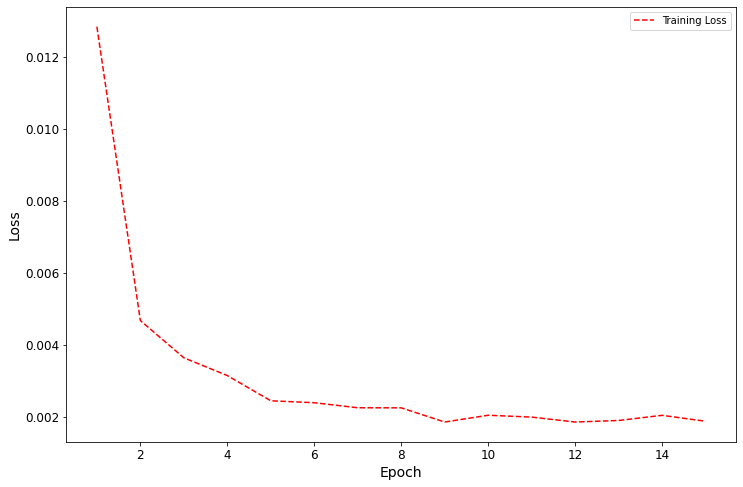

In [24]:
loss_graph(history1)

In [25]:
y_pred_scaled1 = model1.predict(X_test_seq)
y_pred1 = scaler.inverse_transform(y_pred_scaled1)
y_test1 = scaler.inverse_transform(y_test_seq)

In [26]:
ratio1, differences1, outliers1 = evaluate_predictions(y_pred1, y_test1, 0.05)

for i in outliers1.index:
    outliers1[i] = y_pred1[i]
outliers1

117    4158.238281
119    4160.169922
122    4165.875488
118    4158.641602
123    4167.201172
120    4162.562500
121    4164.599609
116    4159.136230
dtype: float64

In [27]:
xticks1 = data[training_size:len(data)]['date']
xticks1 = xticks1[-161:]
xticks_outliers1 = []
for i in outliers1.index:
    xticks_outliers1.append(xticks1.iloc[i])

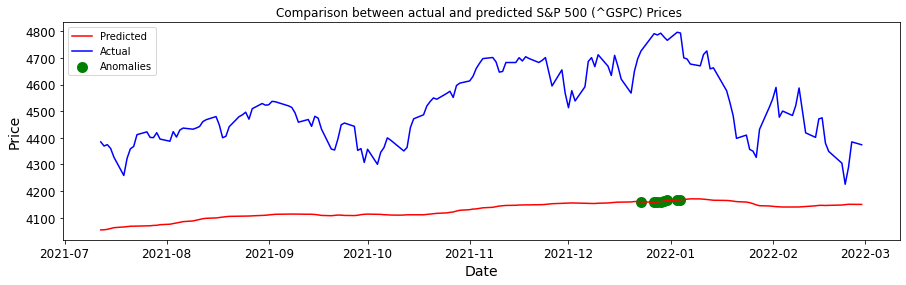

In [28]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots(figsize=(15,4))
axs.plot(xticks1, y_pred1,color='red', label='Predicted')
axs.plot(xticks1, y_test1,color='blue', label='Actual')
axs.scatter(xticks_outliers1, outliers1, color='green', linewidth=5.0, label='Anomalies')
plt.title('Comparison between actual and predicted S&P 500 (^GSPC) Prices ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

#### Model 2

In [29]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train_seq.shape[1],X_train_seq.shape[-1]), dropout=0.5)))
model2.add(Bidirectional(LSTM(units=32, return_sequences=True, dropout=0.5)))
model2.add(Bidirectional(LSTM(units=16, dropout=0.5)))
model2.add(Dense(units=1))
model2.compile(optimizer='rmsprop', loss='mean_squared_error')

In [30]:
history2 = model2.fit(X_train_seq, y_train_seq, epochs=15, batch_size=16)

Epoch 1/15
58/58 [==============================] - 15s 71ms/step - loss: 0.0129
Epoch 2/15
58/58 [==============================] - 4s 72ms/step - loss: 0.0052
Epoch 3/15
58/58 [==============================] - 4s 71ms/step - loss: 0.0038
Epoch 4/15
58/58 [==============================] - 4s 72ms/step - loss: 0.0028
Epoch 5/15
58/58 [==============================] - 4s 74ms/step - loss: 0.0029
Epoch 6/15
58/58 [==============================] - 5s 79ms/step - loss: 0.0026
Epoch 7/15
58/58 [==============================] - 4s 69ms/step - loss: 0.0026
Epoch 8/15
58/58 [==============================] - 4s 69ms/step - loss: 0.0026
Epoch 9/15
58/58 [==============================] - 4s 70ms/step - loss: 0.0023
Epoch 10/15
58/58 [==============================] - 5s 85ms/step - loss: 0.0023
Epoch 11/15
58/58 [==============================] - 4s 75ms/step - loss: 0.0021
Epoch 12/15
58/58 [==============================] - 4s 77ms/step - loss: 0.0021
Epoch 13/15
58/58 [=================

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 90, 128)          37376     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 90, 64)           41216     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 88,993
Trainable params: 88,993
Non-trainable params: 0
__________________________________________________

In [32]:
y_pred_scaled2 = model2.predict(X_test_seq)
y_pred2 = scaler.inverse_transform(y_pred_scaled2)
y_test2 = scaler.inverse_transform(y_test_seq)

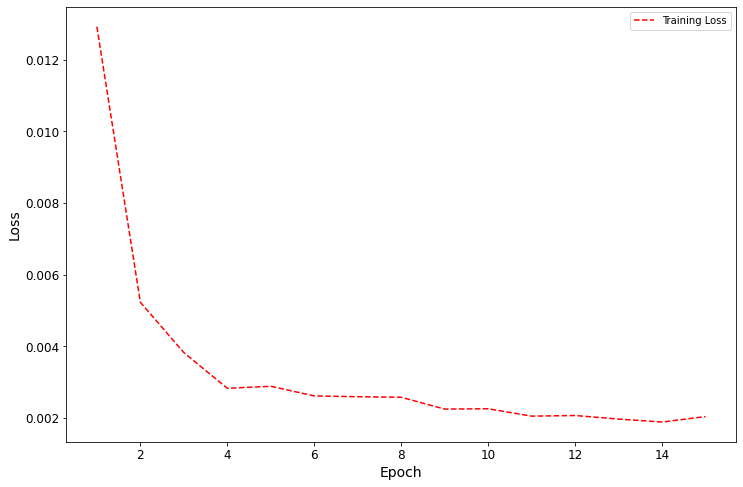

In [33]:
loss_graph(history2)

In [34]:
ratio2, differences2, outliers2 = evaluate_predictions(y_pred2, y_test2, 0.05)

for i in outliers2.index:
    outliers2[i] = y_pred2[i]

xticks2 = data[training_size:len(data)]['date']
xticks2 = xticks2[-161:]
xticks_outliers2 = []
for i in outliers2.index:
    xticks_outliers2.append(xticks2.iloc[i])

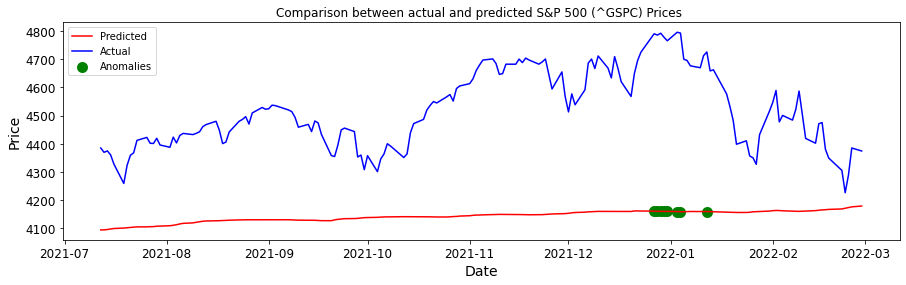

In [35]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots(figsize=(15,4))
axs.plot(xticks2, y_pred2,color='red', label='Predicted')
axs.plot(xticks2, y_test2,color='blue', label='Actual')
axs.scatter(xticks_outliers2,outliers2, color='green', linewidth=5.0, label='Anomalies')
plt.title('Comparison between actual and predicted S&P 500 (^GSPC) Prices ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

#### Model 3

In [44]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train_seq.shape[1],X_train_seq.shape[-1]), dropout=0.5)))
model3.add(Bidirectional(LSTM(units=32, return_sequences=True, dropout=0.5)))
model3.add(Bidirectional(LSTM(units=32, return_sequences=True, dropout=0.5)))
model3.add(Bidirectional(LSTM(units=16, dropout=0.5)))
model3.add(Dense(units=1))
model3.compile(optimizer='rmsprop', loss='mean_squared_error')

In [45]:
history3 = model3.fit(X_train_seq, y_train_seq, epochs=15, batch_size=16)

Epoch 1/15
58/58 [==============================] - 26s 103ms/step - loss: 0.0132
Epoch 2/15
58/58 [==============================] - 7s 114ms/step - loss: 0.0053
Epoch 3/15
58/58 [==============================] - 6s 110ms/step - loss: 0.0041
Epoch 4/15
58/58 [==============================] - 6s 107ms/step - loss: 0.0036
Epoch 5/15
58/58 [==============================] - 6s 104ms/step - loss: 0.0029
Epoch 6/15
58/58 [==============================] - 6s 104ms/step - loss: 0.0026
Epoch 7/15
58/58 [==============================] - 7s 120ms/step - loss: 0.0027
Epoch 8/15
58/58 [==============================] - 7s 119ms/step - loss: 0.0025
Epoch 9/15
58/58 [==============================] - 6s 111ms/step - loss: 0.0026
Epoch 10/15
58/58 [==============================] - 7s 112ms/step - loss: 0.0021
Epoch 11/15
58/58 [==============================] - 6s 103ms/step - loss: 0.0022
Epoch 12/15
58/58 [==============================] - 6s 96ms/step - loss: 0.0022
Epoch 13/15
58/58 [======

In [46]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 90, 128)          37376     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 90, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 90, 64)           24832     
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                

In [47]:
y_pred_scaled3 = model3.predict(X_test_seq)
y_pred3 = scaler.inverse_transform(y_pred_scaled3)
y_test3 = scaler.inverse_transform(y_test_seq)

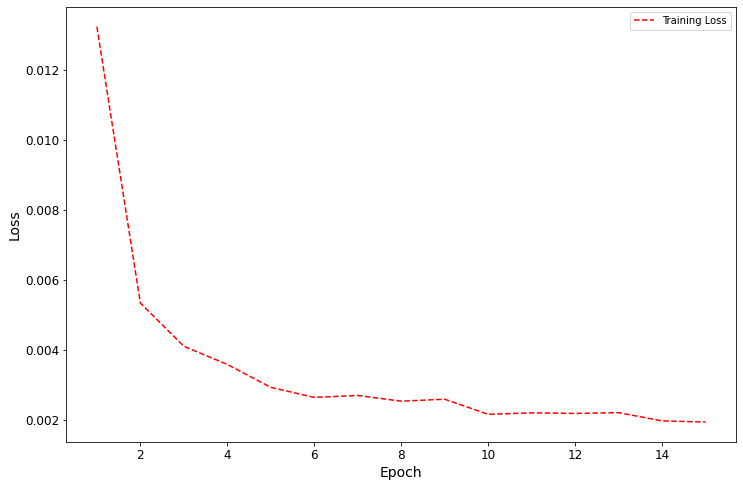

In [48]:
loss_graph(history3)

In [49]:
ratio3, differences3, outliers3 = evaluate_predictions(y_pred3, y_test3, 0.05)

for i in outliers3.index:
    outliers3[i] = y_pred3[i]

xticks3 = data[training_size:len(data)]['date']
xticks3 = xticks3[-161:]
xticks_outliers3 = []
for i in outliers3.index:
    xticks_outliers3.append(xticks3.iloc[i])

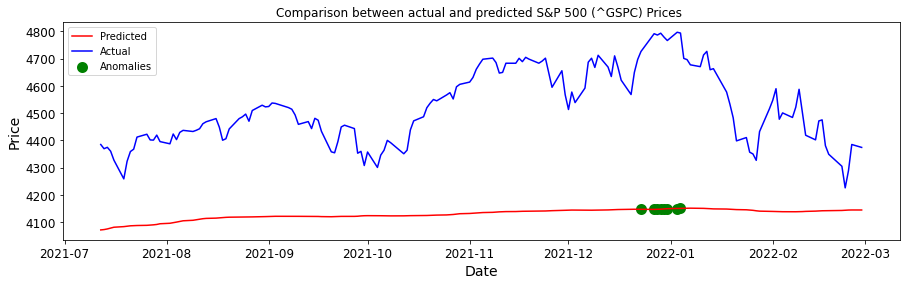

In [50]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots(figsize=(15,4))
axs.plot(xticks3, y_pred3,color='red', label='Predicted')
axs.plot(xticks3, y_test3,color='blue', label='Actual')
axs.scatter(xticks_outliers3, outliers3, color='green', linewidth=5.0, label='Anomalies')
plt.title('Comparison between actual and predicted S&P 500 (^GSPC) Prices ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## Conclusion

The models can be improved, as the predictions don't match well with the actual values. It is important to mention none of the models seem to converge yet. It is possible seeing the loss graphs the differences are decreasing, and probably if we run the models with more epochs they will converge, eventually. <br>
Adding more layers makes the training process take longer and, with the 15 epochs I ran for each model, didn't show much improvement.<br>
There are several ways to try improving the models, by experimenting different hyperparameters like optimizers, loss functions, layers, nodes per layer, etc.